# Advanced Statistical Inference -- Assessed exercise 2019/2020 

**Name:** Irina Moschini

In [0]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.linalg
import warnings
import torch
import torch.nn as nn
import time
import math

from functools import total_ordering
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
def set_seed(seed: int=0):
    np.random.seed(seed)

def args_as_tensors(*index):
    """A simple decorator to convert numpy arrays to torch tensors"""
    def decorator(method):
        def wrapper(*args, **kwargs):
            converted_args = [torch.tensor(a).float() 
                              if i in index and type(a) is np.ndarray else a 
                              for i, a in enumerate(args)]
            return method(*converted_args, **kwargs)
        return wrapper  
    return decorator

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Loading the datasets we saved in the prelimary phase
X_train = np.load('/content/drive/My Drive/asi/X_train_stand.npy', allow_pickle=True)
X_test = np.load('/content/drive/My Drive/asi/X_test_stand.npy', allow_pickle=True)
y_train = np.load('/content/drive/My Drive/asi/y_train.npy', allow_pickle=True)
y_test = np.load('/content/drive/My Drive/asi/y_test.npy', allow_pickle=True)

# Preliminary questions

*a) (code) Download and import the Santander dataset. The labels of the test data are not publicly available, so create your own test set by randomly choosing half of the instances in the original training set.* [3]

In [145]:
data_pd = pd.read_csv('/content/drive/My Drive/asi/train.csv', delimiter=',')
data_pd.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
print('The dataset has', np.shape(data_pd)[0], 'rows and', np.shape(data_pd)[1] - 1, 'features')

The dataset has 200000 rows and 201 features


In [0]:
features_pd = data_pd.drop(['target', 'ID_code'],axis=1)
labels_pd = data_pd['target']

# Transform the dataframes into numpy array
features = features_pd.values
labels = labels_pd.values

In [0]:
# Shuffle and split the dataset into a training set (50%) and a testing set (50%)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.5)

In [0]:
# Saving those datasets
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

*b) (text) Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.* [7]

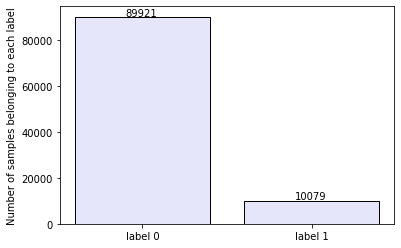

In [11]:
y_train_pd = pd.DataFrame(y_train, columns=['target'])
n_label_0 = y_train_pd['target'].value_counts()[0]
n_label_1 = y_train_pd['target'].value_counts()[1]

y = [n_label_0, n_label_1]
x = [0, 1]

plt.bar(x,y, color = 'lavender', edgecolor = 'black')
x_labels = ['label 0', 'label 1']
plt.xticks(x, x_labels)

labels = [y[0], y[1]]
# Text on the top of each barplot
for i in range(len(x)):
    plt.text(x = x[i]-0.1, y = y[i]+5*10**2, s = labels[i], size = 10)

#Titles and labels    
plt.ylabel('Number of samples belonging to each label')
plt.show()

This histogram shows the repartition of samples of the training set among the 2 labels. We can see thanks that the **distribution is very unbalanced**: there are 89 921 samples belonging to class 0 compared to 10 079 belonging to class 1. Thus, it could be harder to 'learn' the characteristics of the class 1 than the class 0, and class 1 can be overpredicting on unseen data. 

Concerning the dimensionality of the input, **there are a lot of features** (200 in total). We have to be careful that the model don't overfit.

# 1. Bayesian Linear Regression

## Question a

*a) (code) Implement Bayesian linear regression (you should already have an
implementation from the lab sessions)* [10]

We know that the posterior follows this form:

\begin{equation}
p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \sigma_\mathrm{n}) = \mathcal{N}\left(\frac{1}{\sigma^2_\mathrm{n}}\mathbf{\Sigma}\mathbf{X}^\top\mathbf{y}, \mathbf{\Sigma} \right)
\end{equation}

where $\mathbf{\Sigma}^{-1} = \left(\frac{1}{\sigma^2_\mathrm{n}}\mathbf{X}^\top\mathbf{X} + \mathbf{S}^{-1}  \right)$.

Compared to what we did in the lab session 1, let's define the **design matrix** $\mathbf{X}$ without transforming the input to have a multipolynomial input. Thus, the resulting design matrix has the form:

$$
\mathbf{X} = \left[ {\begin{array}{ccccc}
   x_{1_1} & \dots & x_{1_{200}}\\
   x_{2_1} & \dots & x_{2_{200}}\\
   \vdots & &   \vdots \\
   x_{N_1} & \dots & x_{N_{200}}\\
  \end{array} } \right]
$$

In brief, $\mathbf{X} = \mathbf{X_{train}}$.

In [0]:
def compute_posterior(X, y, sigma2priorweights, sigma2noise):
    
    Sigma_inverse = (1/sigma2noise) * np.dot(X.T, X) + (1/sigma2priorweights) * np.eye(len(X[0]))
    posterior_mu =     1/sigma2noise * np.dot(np.dot(scipy.linalg.inv(Sigma_inverse), X.T), y)
    posterior_Sigma =  scipy.linalg.inv(Sigma_inverse)
    
    return posterior_mu, posterior_Sigma

## Question b

*b) (text) Describe any pre-processing that you suggest for this data* [5]

In [144]:
nan_column = 0
for i in range (len(data_pd.columns)):
    column_name = data_pd.columns[i]
    n_nan = sum((data_pd[column_name].astype(str) == 'nan')==True)
    if n_nan > 0:
        nan_column += 1   
        print('Number or nan values in', column_name, ':', sum((data_pd[column_name].astype(str) == 'nan')==True))
if nan_column == 0:
    print('No nan values in the dataset')

No nan values in the dataset


* We checked that there are **no 'nan' values**, the dataset seems well filled. 

* We can work on identifying strange rows, by **removing outliers** for example. We can also **combine rows** that bring the same information.

* We can **normalize the data** so that each feature brings the same quantity of information. 

* As we have a lot of features, we can finally think that there are redundancy of information. Thus, applying a **Principal Component Analysis** (PCA) can be useful. 

In [0]:
# Standardization of the features
sc = StandardScaler()
X_train[:] = sc.fit_transform(X_train[:]) 
X_test[:] = sc.fit_transform(X_test[:]) 

In [0]:
# Saving those datasets
np.save('X_train_stand.npy', X_train)
np.save('X_test_stand.npy', X_test)

## Question c

*c) (code) Treat class labels as continuous and apply regression to the training data. Also, calculate and report the posterior variance of the weights.* [10]

In [0]:
sigma2priorweights = 1
sigma2noise = 1
w_posterior_mu, w_posterior_Sigma = compute_posterior(X_train, y_train, sigma2priorweights, sigma2noise)

We know that the posterior covariance of the weights is equal to $\mathbf{\Sigma}$, so let's compute the diagonal of this matrix to get the variance.

In [91]:
var_weights = w_posterior_Sigma.diagonal()
name_weights = ['feature'+str(i) for i in range(1,len(var_weights)+1)]
print('Shape of the variance of the weights is', np.shape(var_weights))

Shape of the variance of the weights is (200,)


Text(0.5, 1.0, 'Value of the first 50 biggest variance')

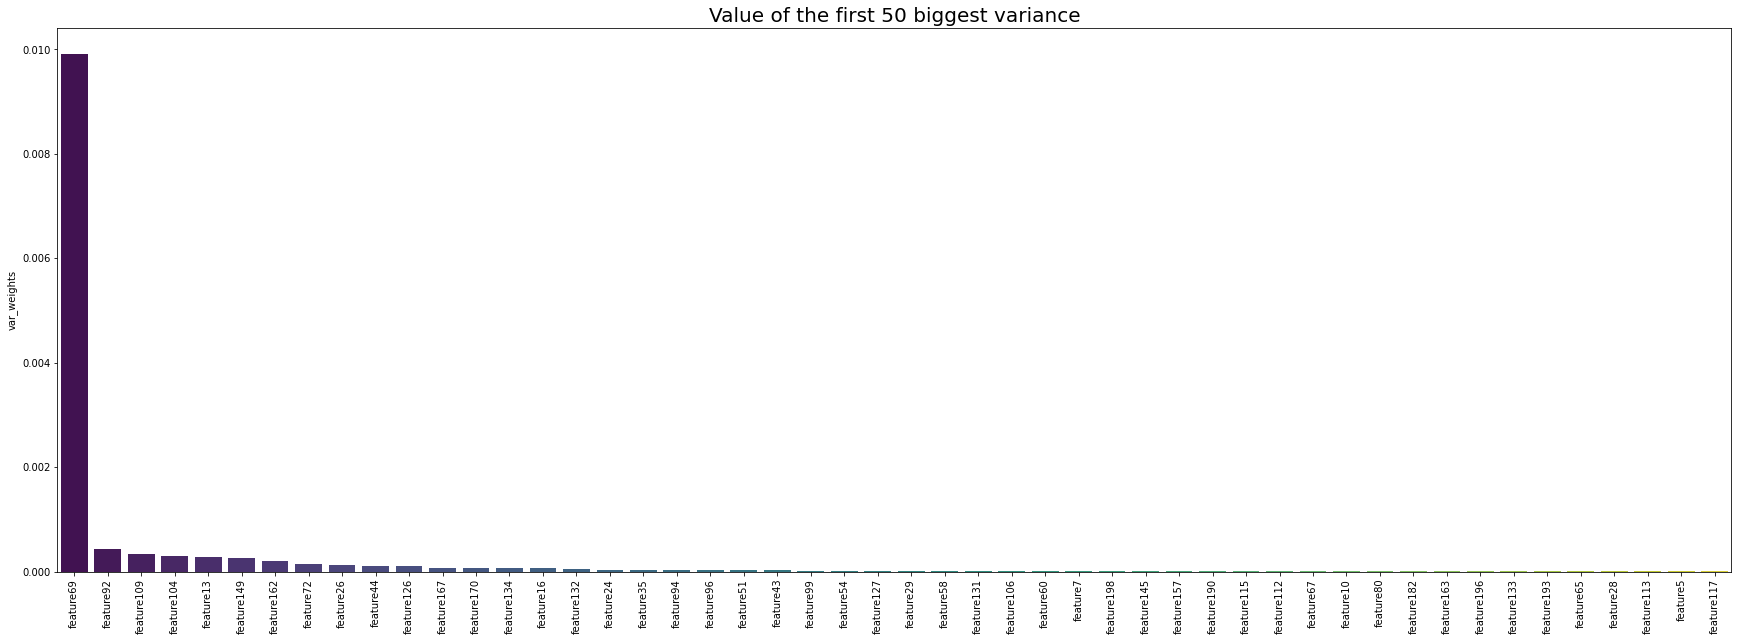

In [92]:
results_pd = pd.DataFrame(var_weights, index = name_weights, columns = ['var_weights']).sort_values(by=['var_weights'],ascending=False).head(50)

plt.figure(figsize=(30,10))
g = sns.barplot(x=results_pd.index, y=results_pd.var_weights,palette = 'viridis')
g.set_xticklabels(results_pd.index, rotation=90)
plt.title('Value of the first 50 biggest variance', fontsize=20)

## Question d

*d) (text) Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy.* [5]

The output of a prediction is going to be a number near 0 or 1: the more the value is closed to one of these numbers, the more it is sure about its answer (it is actually a kind of probability that the class belongs to 1, but can have values smaller than 0 and bigger than 1). Thus, we can **set a threshold** (0.5 seems to be the best threshold to set). If the value is smaller than this threshold (that can be chosen smaller than 0.5 in our case, for more restriction), the predicted label will be 0. Otherwise, it will be 1. With this method, the output is discretized and the threshold can be set depending on the dataset.

Let's first implement the code to do a prediction on unseen data.

In [0]:
def compute_predictive(Xnew, w_posterior_mu, w_posterior_Sigma, sigma2noise):
    y_posterior_mu = np.reshape(np.dot(Xnew, w_posterior_mu),(-1, 1))
    y_posterior_sigma2 = np.reshape(np.diag(sigma2noise + np.dot(np.dot(Xnew, w_posterior_Sigma), np.transpose(Xnew))), (-1,1))
    return y_posterior_mu, y_posterior_sigma2

Let's now compute what the predictions would be on the testing set, by setting a threshold at 0.5.

In [0]:
y_posterior_mu_1, _ = compute_predictive(X_test[:25000], w_posterior_mu, w_posterior_Sigma, sigma2noise)
y_posterior_mu_2, _ = compute_predictive(X_test[25000:50000], w_posterior_mu, w_posterior_Sigma, sigma2noise)
y_posterior_mu_3, _ = compute_predictive(X_test[50000:75000], w_posterior_mu, w_posterior_Sigma, sigma2noise)
y_posterior_mu_4, _ = compute_predictive(X_test[75000:], w_posterior_mu, w_posterior_Sigma, sigma2noise)
y_posterior_mu = np.concatenate((y_posterior_mu_1, y_posterior_mu_2, y_posterior_mu_3, y_posterior_mu_4))

In [97]:
print('Minimum value among the output', min(y_posterior_mu))
print('Maximum value among the output', max(y_posterior_mu))

Minimum value among the output [-0.49919931]
Maximum value among the output [0.77596898]


As mentionned before, we can see that the minimum value is lower than 0 (-0.50), and shows how sure the algorithm is to predict the associated sample as belonging to the class 0. 

However, we can also see that the maximum value is 0.78 (not even 1). It shows that the value 1 is very hard to predict as no sample has a predicted value near 1. 

Let's define a function that, given a threshold, allows to discretize the output. 

In [0]:
def discrete (threshold, y_posterior_mu):
  y_pred = []
  for i in range(len(y_posterior_mu)):
    proba = y_posterior_mu[i]
    if proba > threshold:
      y_pred.append(1)
    else: 
      y_pred.append(0)
  return y_pred

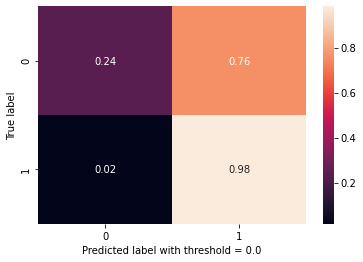

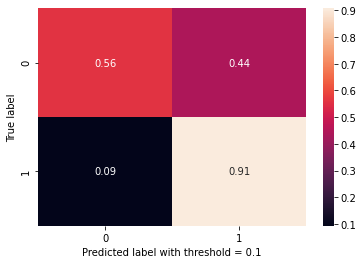

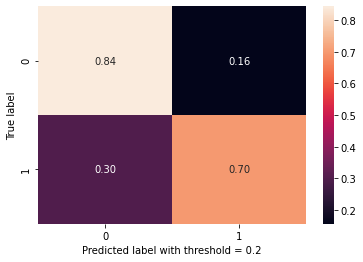

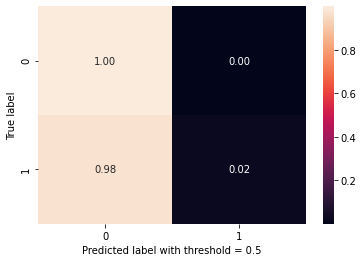

In [161]:
y_pred_reg00 = discrete (0.0, y_posterior_mu)
y_pred_reg01 = discrete (0.1, y_posterior_mu)
y_pred_reg02 = discrete (0.2, y_posterior_mu)
y_pred_reg05 = discrete (0.5, y_posterior_mu)

columns00 = ['True label','Predicted label']
columns01 = ['True label','Predicted label']
columns05 = ['True label','Predicted label']
columns02 = ['True label','Predicted label']

results_pd00 = pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_pred_reg00)],axis=1)
results_pd00.columns = columns00
results_pd01 = pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_pred_reg01)],axis=1)
results_pd01.columns = columns01
results_pd02 = pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_pred_reg02)],axis=1)
results_pd02.columns = columns02
results_pd05 = pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_pred_reg05)],axis=1)
results_pd05.columns = columns05

confusion_matrix00 = pd.crosstab(results_pd00['True label'], results_pd00['Predicted label'], rownames=['True label'], colnames=['Predicted label with threshold = 0.0']).astype('float') / confusion_matrix00.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_matrix00, annot=True, fmt='.2f')
plt.show()
    
confusion_matrix01 = pd.crosstab(results_pd01['True label'], results_pd01['Predicted label'], rownames=['True label'], colnames=['Predicted label with threshold = 0.1']).astype('float') / confusion_matrix01.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_matrix01, annot=True, fmt='.2f')
plt.show()

confusion_matrix02 = pd.crosstab(results_pd02['True label'], results_pd02['Predicted label'], rownames=['True label'], colnames=['Predicted label with threshold = 0.2']).astype('float') / confusion_matrix02.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_matrix02, annot=True, fmt='.2f')
plt.show()

confusion_matrix05 = pd.crosstab(results_pd05['True label'], results_pd05['Predicted label'], rownames=['True label'], colnames=['Predicted label with threshold = 0.5']).astype('float') / confusion_matrix05.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_matrix05, annot=True, fmt='.2f')
plt.show()

These confusion matrices with different threshold allow to **highlight the importance of setting the good threshold**. 

In fact, the more intuitive thresold is 0.5. However, as the third confusion matrix shows, putting this threshold lead to predict class 0 almost everytime. 98% of class 1 samples are predicted 0. This is due to the unbalanced repartition of the classes among the dataset, as mentioned before: **the model predict almost only 0**. 

However, decreasing this threshold puts **more restriction** on the dominant class 0. With a threshold at 0.1, the results are better as class 1 are more often predicted, and 91% of the sample of class 1 is well predicted. However, this threshold is maybe too restrictive as class 0 is well labeled only 56% of the time. 

The threshold can't be too low either, otherwise **class 1 will be overpredicted**, as the threshold at 0.0 shows (76% of class 0 samples are predicted as belonging to class 1).

It finally appears that **the best threshold is 0.2**, as it allows to predict well 84% of class 0 samples, and 70% of class 1. 

In [164]:
print('Testing accuracy with a threshold of 0.0:', accuracy_score(y_test, y_pred_reg00)*100, '%')
print('Testing accuracy with a threshold of 0.1:', accuracy_score(y_test, y_pred_reg01)*100, '%')
print('Testing accuracy with a threshold of 0.2:', accuracy_score(y_test, y_pred_reg02)*100, '%')
print('Testing accuracy with a threshold of 0.5:', accuracy_score(y_test, y_pred_reg05)*100, '%')

Testing accuracy with a threshold of 0.0: 31.705 %
Testing accuracy with a threshold of 0.1: 59.47 %
Testing accuracy with a threshold of 0.2: 82.98100000000001 %
Testing accuracy with a threshold of 0.5: 90.205 %


It is very interesting to remark that **when the threshold increases, the accuracy increases too**. Our best threshold (0.2) has an accuracy of 83% compared to 90% with a threshold at 0.5. This second accuracy is better only because more 0 are predicted.

We can conclude that **we can't rely on the accuracy**.

# 2. Logistic Regression

## Question a

*a) (code) The goal is to implement a Bayesian logistic regression classifier; assume a Gaussian prior on the parameters. As a first step, implement a Markov chain Monte Carlo inference algorithm to infer parameters (you should already have an implementation of the Metropolis- Hastings algorithm from the lab sessions).* [10]


For this question, we can directly take the lines of code we implemented during the lab session 3 (first notebook).

In [0]:
def logistic(z):
    return 1/(1+np.exp(-z))               ## *** TO COMPLETE *** ##

jitter = 10**-10    # do as we did for bayesian inference
class BernoulliLikelihood():
    def logdensity(self, y, p):
        return y*np.log(p + jitter)+(1-y)*np.log(1 - p + jitter)
        #np.dot(y.T, np.log(p)) + np.dot((1-y).T, np.log(1-p))   ## *** TO COMPLETE *** ##
        
class NormalPrior():
    def __init__(self, sigma2x):
        self.sigma2x = sigma2x
        
    def logdensity(self, x):
        return -1/(2*self.sigma2x)*np.dot(x, x.T)       ## *** TO COMPLETE *** ##

In [0]:
class MHSampler():
    @property
    def samples(self):
        return self._samples
    @samples.getter    
    def samples(self):
        return np.asarray(self._samples)
    
    def __init__(self, initial_sample, likelihood, prior):
        self.likelihood = likelihood
        self.prior = prior
        self._samples = [initial_sample]
        
        
    def unnormalized_logposterior(self, w, X, y):
        p = logistic(np.dot(X,w.T))
        log_likelihood = np.sum(BernoulliLikelihood().logdensity(y, p))            ## *** TO COMPLETE *** ##
        log_prior = self.prior.logdensity(w)        ## *** TO COMPLETE *** ##
        return log_likelihood + log_prior


    def step(self, X, y, step_proposal):
        w_prev = self._samples[-1]
        w_proposal = np.random.normal(w_prev, np.eye(len(w_prev))*step_proposal, w_prev.shape)    ## *** TO COMPLETE *** ##
        
        log_gw_prev = self.unnormalized_logposterior(w_prev, X, y)     ## *** TO COMPLETE *** ##
        log_gw_proposal = self.unnormalized_logposterior(w_proposal, X, y)   ## *** TO COMPLETE *** ##
        acceptance_ratio = np.exp(log_gw_proposal - log_gw_prev)            ## *** TO COMPLETE *** ##
        
        if acceptance_ratio >= 1:            ## *** TO COMPLETE *** ##
            self._samples.append(w_proposal)
        else:
            u = np.random.uniform(0,1)            ## *** TO COMPLETE *** ##
            if u <= acceptance_ratio:           ## *** TO COMPLETE *** ##
                self._samples.append(w_proposal)
            else:
                self._samples.append(w_prev)

        return min(acceptance_ratio, 1)

In [0]:
set_seed()

likelihood = BernoulliLikelihood()             ## *** TO COMPLETE *** ##
prior = NormalPrior(1)          ## *** TO COMPLETE *** ##

starting_point = X_train[np.random.randint(0, len(X_train[0]),1)]
## *** TO COMPLETE *** ##
sampler = MHSampler(starting_point, likelihood, prior)         ## *** TO COMPLETE *** ##

In [0]:
set_seed()
step_proposal = 0.8
y_train = y_train.reshape(np.shape(y_train)[0],1)

for _ in range(10000):
  sampler.step(X_train, y_train, step_proposal)    ## *** TO COMPLETE *** ##

## Question b

*b) (code) Implement the variational approximation we studied in the course to obtain an approximation to the posterior over model parameters (you should already have an implementation of the from the lab sessions).* [10]

For this question, we can directly take the lines of code we implemented during the lab session 3 (second notebook).

In [0]:
warnings.filterwarnings("ignore")
def set_seed(seed: int=0):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [0]:
jitter = 1e-10

class Distribution(nn.Module):  
    pass
        
class Bernoulli_torch(Distribution):
    @args_as_tensors(1, 2)
    def logdensity(self, y, p):
        return (y*torch.log(p+jitter)+(1-y)*torch.log(1-p+jitter)) ## *** TO COMPLETE *** ##

In [0]:
class NormalDiagonal(Distribution):
    @property
    def var(self):
        return self.logvar.exp()
    
    def extra_repr(self):
        return 'train=%s' % self.train
    
    def __init__(self, d, train=True):
        super(NormalDiagonal, self).__init__()
        self.train = train
        self.d = d
        self.mean = nn.Parameter(torch.zeros(d), requires_grad=train)
        self.logvar = nn.Parameter(torch.zeros(d), requires_grad=train)
    
    def sample(self, n=1):
        eps = torch.randn(n,self.d,requires_grad=False)         ## *** TO COMPLETE *** ##
        samples = self.mean + eps*(torch.sqrt((torch.exp(self.logvar))))        ## *** TO COMPLETE *** ##    # shape: [n x self.d]
        return samples

In [0]:
_KL_REGISTRY = {}  # Source of truth mapping a few general (type, type) pairs to functions.
_KL_MEMOIZE = {}  # Memoized version mapping many specific (type, type) pairs to functions.

@total_ordering
class _Match(object):
    __slots__ = ['types']

    def __init__(self, *types):
        self.types = types

    def __eq__(self, other):
        return self.types == other.types

    def __le__(self, other):
        for x, y in zip(self.types, other.types):
            if not issubclass(x, y):
                return False
            if x is not y:
                break
        return True

def _dispatch_kl(type_q, type_p):
    matches = [(super_q, super_p) for super_q, super_p in _KL_REGISTRY
               if issubclass(type_q, super_q) and issubclass(type_p, super_p)]
    if not matches:
        return NotImplemented
    left_q, left_p = min(_Match(*m) for m in matches).types
    right_p, right_q = min(_Match(*reversed(m)) for m in matches).types
    left_fun = _KL_REGISTRY[left_q, left_p]
    right_fun = _KL_REGISTRY[right_q, right_p]
    if left_fun is not right_fun:
        logger.warning('Ambiguous kl_divergence({}, {}). Please register_kl({}, {})'.format(
            type_q.__name__, type_p.__name__, left_q.__name__, right_p.__name__))
    return left_fun


def register_kl(type_q, type_p):
    """
    Decorator to register a pairwise function with kl_divergence.
    Usage:

        @register_kl(Normal, Normal)
        def kl_normal_normal(q, p):
            # insert implementation here
    """
    if not isinstance(type_q, type) and issubclass(type_q, BaseDistribution):
        raise TypeError('Expected type_q to be a Distribution subclass but got {}'.format(type_q))
    if not isinstance(type_p, type) and issubclass(type_p, BaseDistribution):
        raise TypeError('Expected type_p to be a Distribution subclass but got {}'.format(type_p))
    
    def decorator(fun):
        _KL_REGISTRY[type_q, type_p] = fun
        _KL_MEMOIZE.clear()  # reset since lookup order may have changed
        print('KL divergence between \'%s\' and \'%s\' registered.' % (type_q.__name__, type_p.__name__))
        return fun
    return decorator


def kl_divergence(q, p):
    r"""Compute Kullback-Leibler divergence KL(p|q) between two distributions."""
    try:
        fun = _KL_MEMOIZE[type(q), type(p)]
    except KeyError:
        fun = _dispatch_kl(type(q), type(p))
        _KL_MEMOIZE[type(q), type(p)] = fun
    if fun is NotImplemented:
        raise NotImplementedError('KL divergence for pair %s - %s not registered' % (type(q).__name__,
                                                                                     type(p).__name__))
    return fun(q, p)

In [0]:
class NormalFullCovariance(Distribution): 
    def extra_repr(self):
        return 'train=%s' % self.train
    
    def __init__(self, d, train=True):
        super(NormalFullCovariance, self).__init__()
        self.train = train
        self.d = d
        self.mean = nn.Parameter(torch.zeros(d), requires_grad=train)
        self.cholesky_cov = nn.Parameter(torch.eye(d), requires_grad=train)
    
    def sample(self, n=3):
        eps = torch.randn(n, self.d)      ## *** TO COMPLETE *** ##
        samples = self.mean+eps@ torch.tril(self.cholesky_cov)      ## *** TO COMPLETE *** ##
        return samples

In [98]:
@register_kl(NormalFullCovariance, NormalDiagonal)
def _kl_normalfullcov_normaldiagonal(q, p):
    kl = (
        torch.sum(p.logvar.exp() * torch.diag(q.cholesky_cov)**2) + 
        torch.sum(p.logvar.exp() * (p.mean - q.mean) ** 2) +
        torch.sum(p.logvar) + 
        torch.sum(torch.log(torch.diag(q.cholesky_cov)) ** 2) -
        len(q.mean)
    )
    return .5 * kl

KL divergence between 'NormalFullCovariance' and 'NormalDiagonal' registered.


In [0]:
def logistic_torch(z):
    return 1/(1+torch.exp(-z))      ## *** TO COMPLETE *** ##


class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        
        self.prior_w = NormalDiagonal(input_dim, train=False)     ## *** TO COMPLETE *** ##
        self.posterior_w = NormalFullCovariance(input_dim)      ## *** TO COMPLETE *** ##
        
    @args_as_tensors(1)
    def predict_y(self, X, mc_samples=1):
        w_samples = torch.unsqueeze(self.posterior_w.sample(mc_samples), dim=2)     ## *** TO COMPLETE *** ##
        y_samples = logistic_torch(X @ w_samples)      ## *** TO COMPLETE *** ##
        return y_samples

In [0]:
class VariationalObjective(nn.Module):    
    def __init__(self, model, likelihood, N, mc_samples=1):
        super(VariationalObjective, self).__init__()
        self.N = N
        self.model = model
        self.likelihood = likelihood
        self.mc_samples = mc_samples
        
    def expected_loglikelihood(self, Xbatch, ybatch):
        ypred = model.predict_y(Xbatch,self.mc_samples)     ## *** TO COMPLETE *** ##
        logliks = (1/self.mc_samples)*(self.N/(len(Xbatch)))*torch.sum(likelihood.logdensity(ybatch,ypred))     ## *** TO COMPLETE *** ##
        return logliks      ## *** TO COMPLETE *** ##


    def kl(self):
        return kl_divergence(self.model.posterior_w, self.model.prior_w)      ## *** TO COMPLETE *** ##
    
    def compute_objective(self, Xbatch, ybatch):
        return -self.expected_loglikelihood(Xbatch, ybatch)+self.kl()       ## *** TO COMPLETE *** ##

In [0]:
class Summary:
    @property
    def data(self):
        data = pd.DataFrame(self._data, columns=['step', self.name, 'time'])
        data.time = data.time - data.time.iloc[0]
        return data
    
    def __init__(self, name):
        """A simple class to store some values during optimization"""
        self.name = str(name)
        self._data = []
    
    def append(self, step, value):
        self._data.append([step, float(value.detach().numpy()), time.time()])

In [0]:
class Dataset():
    def __init__(self, X, y, minibatch_size):
        self.X = X
        self.y = y 
        self.minibatch_size = min(minibatch_size, len(self.X))
        self._i = 0  
    def next_batch(self):  
        if len(self.X) <= self._i + self.minibatch_size:
            shuffle = np.random.permutation(len(self.X))
            self.X = self.X[shuffle]
            self.y = self.y[shuffle]
            Xbatch = self.X[self._i:]
            ybatch = self.y[self._i:]
            self._i = 0
            return Xbatch, ybatch

        Xbatch = self.X[self._i:self._i + self.minibatch_size]
        ybatch = self.y[self._i:self._i + self.minibatch_size]
        self._i += self.minibatch_size
        return Xbatch, ybatch

In [0]:
dataset = Dataset(X_train, y_train, minibatch_size=128)

likelihood = Bernoulli_torch()
model = LogisticRegression(len(X_train[0]))    ## *** TO COMPLETE *** ##

nelbo = VariationalObjective(model,likelihood,len(X_train), 1000)    ## *** TO COMPLETE *** ##

In [0]:
nelbo_summary = Summary('nelbo')
nll_summary = Summary('expected_loglik')
kl_summary = Summary('kl')

optim = torch.optim.SGD(filter(lambda p: p.requires_grad,model.parameters()), lr = 10**-12)     ## *** TO COMPLETE *** ##
num_iterations = 1500

for step in range(num_iterations):
    ## *** TO COMPLETE *** ##
    optim.zero_grad()
    Xbatch, ybatch = dataset.next_batch()     ## *** TO COMPLETE *** ##
    loss = nelbo.compute_objective(Xbatch, ybatch)      ## *** TO COMPLETE *** ##
    
    nelbo_summary.append(step, loss)
    nll_summary.append(step, loss - nelbo.kl())
    kl_summary.append(step, nelbo.kl())

    ## *** TO COMPLETE *** ##
    ## *** TO COMPLETE *** ##
    loss.backward()
    optim.step()

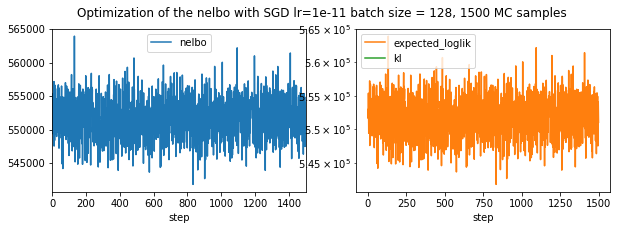

In [145]:
fig, axs = plt.subplots(1, 2, figsize=[10, 3])

nelbo_summary.data.plot(x='step', y='nelbo', ax=axs[0]);
nll_summary.data.plot(x='step', y='expected_loglik', ax=axs[1], c='C1');
kl_summary.data.plot(x='step', y='kl', ax=axs[1], c='C2');
axs[1].semilogy();
fig.suptitle('Optimization of the nelbo with SGD lr=1e-11 batch size = 128, 1500 MC samples')
axs[0].margins(0, 0.05)

## Question c

*c) (code) Based on samples from the posterior over model parameters, write a function that computes the predictive distribution, and write the necessary functions to evaluate classification metrics such as the log-likelihood on test data and error rate.* [10]

### Markov Chain Monte Carlo

Let's first do prediction thanks to the **Markov chain Monte Carlo inference algorithm** we implemented in question 2 a. 

To do the predictions, let's first define the function $\mathbf{predict}$ that computes the predictive distribution over unseen data, and save the output for each set of parameters we are going to try. 

In [0]:
def predict(x_new, w_samples):
    S = len(w_samples)
    return (1/S)*np.sum(logistic(np.dot(w_samples, x_new)))     ## *** TO COMPLETE *** ##

In [0]:
y_pred_08_10000 = []
for x_test in X_test:
  pred = predict(x_test, sampler.samples)
  y_pred_08_10000.append(pred)

In [0]:
np.save('y_pred_08_10000.npy', y_pred_08_10000)

Now that the prediction is done, let's transform the outputs to have discrete labels, and not continuous. We can use the function $\mathbf{discrete}$ I defined previously (question 1 d), with value of the threshold the more intuitive: threshold = 0.5. Let's then compute metrics such as the log-likelihood on test data, the error rate, the accuracy and the confusion matrix. 



> Number of steps = 10 000, step proposal = 0.1



In [0]:
y_pred_01_10000 = np.load('/content/drive/My Drive/asi/y_pred_01_10000.npy', allow_pickle=True)

In [87]:
y_pred_01_10000_discrete = discrete(0.5, y_pred_01_10000)

accuracy_01_10000 = accuracy_score(y_test, y_pred_01_10000_discrete)*100
print('Testing accuracy:', accuracy_01_10000, '%')
log_likelihood_01_10000 = np.sum(BernoulliLikelihood().logdensity(y_test,np.array(y_pred_01_10000_discrete)))
print('Testing log-likelihood =', log_likelihood_01_10000)

fpr, tpr, _ = roc_curve(y_test, y_pred_01_10000_discrete)
fpr_01_10000 = fpr[1]
tpr_01_10000 = tpr[1]
print('False Positive Rate of the MCMC sampler on the Testing set :', fpr_01_10000)
print('True Positive Rate of the MCMC sampler n the Testing set :', tpr_01_10000)

Testing accuracy: 55.062 %
Testing log-likelihood = -1034735.6890841584
False Positive Rate of the MCMC sampler on the Testing set : 0.471066113957391
True Positive Rate of the MCMC sampler n the Testing set : 0.7453837708354127


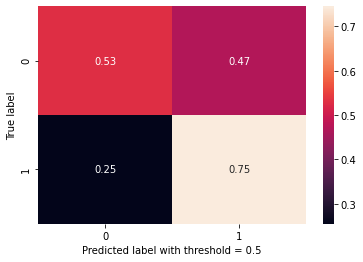

In [75]:
columns = ['True label','Predicted label']

results_pd = pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_pred_01_10000_discrete)],axis=1)
results_pd.columns = columns

confusion_matrix = pd.crosstab(results_pd['True label'], results_pd['Predicted label'], rownames=['True label'], colnames=['Predicted label with threshold = 0.5']).astype('float') 
confusion_matrix = confusion_matrix/ confusion_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_matrix, annot=True, fmt='.2f')
plt.show()



> Number of steps = 1 000, step proposal = 0.1



In [0]:
y_pred_01_1000 = np.load('/content/drive/My Drive/asi/y_pred_01_1000.npy', allow_pickle=True)

In [89]:
y_pred_01_1000_discrete = discrete(0.5, y_pred_01_1000)

accuracy_01_1000 = accuracy_score(y_test, y_pred_01_1000_discrete)*100
print('Testing accuracy:', accuracy_01_1000, '%')
log_likelihood_01_1000 = np.sum(BernoulliLikelihood().logdensity(y_test,np.array(y_pred_01_1000_discrete)))
print('Testing log-likelihood =', log_likelihood_01_1000)

fpr, tpr, _ = roc_curve(y_test, y_pred_01_1000_discrete)
fpr_01_1000 = fpr[1]
tpr_01_1000 = tpr[1]
print('False Positive Rate of the MCMC sampler on the Testing set :', fpr_01_1000)
print('True Positive Rate of the MCMC sampler n the Testing set :', tpr_01_1000)

Testing accuracy: 54.959 %
Testing log-likelihood = -1037107.3517299523
False Positive Rate of the MCMC sampler on the Testing set : 0.4723997288316422
True Positive Rate of the MCMC sampler n the Testing set : 0.7470805469607745


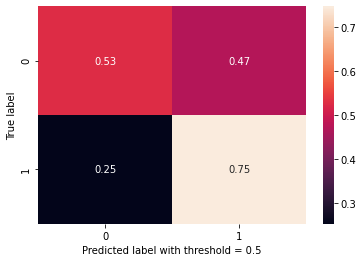

In [80]:
columns = ['True label','Predicted label']

results_pd = pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_pred_01_1000_discrete)],axis=1)
results_pd.columns = columns

confusion_matrix = pd.crosstab(results_pd['True label'], results_pd['Predicted label'], rownames=['True label'], colnames=['Predicted label with threshold = 0.5']).astype('float') 
confusion_matrix = confusion_matrix/ confusion_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_matrix, annot=True, fmt='.2f')
plt.show()



> Number of steps = 10 000, step proposal = 0.8



In [0]:
y_pred_08_10000 = np.load('/content/drive/My Drive/asi/y_pred_08_10000.npy', allow_pickle=True)

In [90]:
y_pred_08_10000_discrete = discrete(0.5, y_pred_08_10000)

accuracy_08_10000 = accuracy_score(y_test, y_pred_08_10000_discrete)*100
print('Testing accuracy:', accuracy_08_10000, '%')
log_likelihood_08_10000 = np.sum(BernoulliLikelihood().logdensity(y_test,np.array(y_pred_08_10000_discrete)))
print('Testing log-likelihood =', log_likelihood_08_10000)

fpr, tpr, _ = roc_curve(y_test, y_pred_08_10000_discrete)
fpr_08_10000 = fpr[1]
tpr_08_10000 = tpr[1]
print('False Positive Rate of the MCMC sampler on the Testing set :', fpr_08_10000)
print('True Positive Rate of the MCMC sampler n the Testing set :', tpr_08_10000)

Testing accuracy: 54.215999999999994 %
Testing log-likelihood = -1054215.5589709724
False Positive Rate of the MCMC sampler on the Testing set : 0.47574487947455574
True Positive Rate of the MCMC sampler n the Testing set : 0.7029643677013674


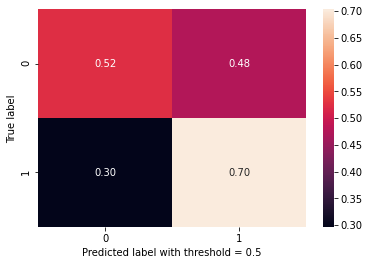

In [91]:
columns = ['True label','Predicted label']

results_pd = pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_pred_08_10000_discrete)],axis=1)
results_pd.columns = columns

confusion_matrix = pd.crosstab(results_pd['True label'], results_pd['Predicted label'], rownames=['True label'], colnames=['Predicted label with threshold = 0.5']).astype('float') 
confusion_matrix = confusion_matrix/ confusion_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_matrix, annot=True, fmt='.2f')
plt.show()

### Variational inference

In [0]:
with torch.no_grad():
  n_samples= 1500
  y_pred_vi = (1/n_samples)*(torch.sum(model.predict_y(X_test, n_samples),dim=0).detach().numpy())
  y_pred_vi = np.array(y_pred_vi)

Now that we have the prediction (continuous), let's discretize it with the $\mathbf{discrete}$ function I defined earlier. 



> Learning rate = 1e-2, optimizer = SGD, number of iteration = 1500, batch_size = 128



Because of a very small learning rate, the algorithm do not converge, and we can't predict anything.



> Learning rate = 1e-9, optimizer = SGD, number of iteration = 1500, batch_size = 128



In [0]:
y_pred_vi_discrete = discrete(0.5, y_pred_vi)

In [124]:
accuracy_vi = accuracy_score(y_test, y_pred_vi_discrete)*100
print('Testing accuracy:', accuracy_01_10000, '%')

Bernouilli_vi = Bernoulli_torch()
log_likelihood_vi=0
for i in range(10):
    log_likelihood_vi = log_likelihood_vi + (1/1000)*(len(X_test[i*10000:(i+1)*10000])/(128))\
                        *torch.sum(Bernouilli_vi.logdensity(y_test[i*10000:(i+1)*10000],
                                                   predictions_vi[i*10000:(i+1)*10000]))
   
print('Testing loglikelyhood = {}'.format(log_likelihood_vi.detach().numpy()))

fpr, tpr, _ = roc_curve(y_test, y_pred_08_10000_discrete)
fpr_vi = fpr[1]
tpr_vi = tpr[1]
print('False Positive Rate with variational inference on the Testing set :', fpr_vi)
print('True Positive Rate with variational inference on the Testing set :', tpr_vi)

Testing accuracy: 55.062 %
Testing loglikelyhood = -54499832.0
False Positive Rate with variational inference on the Testing set : 0.47574487947455574
True Positive Rate with variational inference on the Testing set : 0.7029643677013674


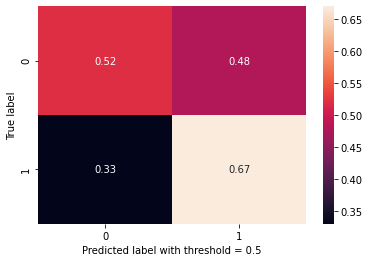

In [125]:
columns = ['True label','Predicted label']

results_pd = pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_pred_vi_discrete)],axis=1)
results_pd.columns = columns

confusion_matrix = pd.crosstab(results_pd['True label'], results_pd['Predicted label'], rownames=['True label'], colnames=['Predicted label with threshold = 0.5']).astype('float') 
confusion_matrix = confusion_matrix/ confusion_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_matrix, annot=True, fmt='.2f')
plt.show()



> Learning rate = 1e-11, optimizer = SGD, number of iteration = 1500, batch_size = 128



In [0]:
y_pred_vi_discrete = discrete(0.5, y_pred_vi)
np.save('y_pred_SGD_11', y_pred_vi_discrete)

In [154]:
accuracy_vi = accuracy_score(y_test, y_pred_vi_discrete)*100
print('Testing accuracy:', accuracy_01_10000, '%')

Bernouilli_vi = Bernoulli_torch()
log_likelihood_vi=0
for i in range(10):
    log_likelihood_vi = log_likelihood_vi + (1/1000)*(len(X_test[i*10000:(i+1)*10000])/(128))\
                        *torch.sum(Bernouilli_vi.logdensity(y_test[i*10000:(i+1)*10000],
                                                   predictions_vi[i*10000:(i+1)*10000]))
   
print('Testing loglikelyhood = {}'.format(log_likelihood_vi.detach().numpy()))

fpr, tpr, _ = roc_curve(y_test, y_pred_08_10000_discrete)
fpr_vi = fpr[1]
tpr_vi = tpr[1]
print('False Positive Rate with variational inference on the Testing set :', fpr_vi)
print('True Positive Rate with variational inference on the Testing set :', tpr_vi)

Testing accuracy: 55.062 %
Testing loglikelyhood = -54499832.0
False Positive Rate with variational inference on the Testing set : 0.47574487947455574
True Positive Rate with variational inference on the Testing set : 0.7029643677013674


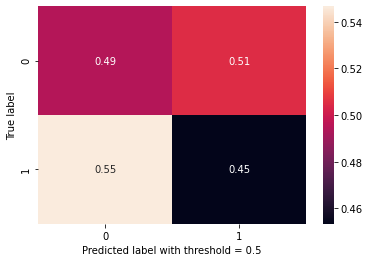

In [150]:
columns = ['True label','Predicted label']

results_pd = pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_pred_vi_discrete)],axis=1)
results_pd.columns = columns

confusion_matrix = pd.crosstab(results_pd['True label'], results_pd['Predicted label'], rownames=['True label'], colnames=['Predicted label with threshold = 0.5']).astype('float') 
confusion_matrix = confusion_matrix/ confusion_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_matrix, annot=True, fmt='.2f')
plt.show()



> Learning rate = 1e-5, optimizer = Adam, number of iteration = 1500 



In [0]:
np.save('y_pred_Adam_5.npy', y_pred_vi)

In [0]:
y_pred_discrete = discrete(0.5, y_pred_vi)

In [142]:
accuracy_vi = accuracy_score(y_test, y_pred_vi_discrete)*100
print('Testing accuracy:', accuracy_01_10000, '%')

Bernouilli_vi = Bernoulli_torch()
log_likelihood_vi=0
for i in range(10):
    log_likelihood_vi = log_likelihood_vi + (1/1000)*(len(X_test[i*10000:(i+1)*10000])/(128))\
                        *torch.sum(Bernouilli_vi.logdensity(y_test[i*10000:(i+1)*10000],
                                                   predictions_vi[i*10000:(i+1)*10000]))
   
print('Testing loglikelyhood = {}'.format(log_likelihood_vi.detach().numpy()))

fpr, tpr, _ = roc_curve(y_test, y_pred_08_10000_discrete)
fpr_vi = fpr[1]
tpr_vi = tpr[1]
print('False Positive Rate with variational inference on the Testing set :', fpr_vi)
print('True Positive Rate with variational inference on the Testing set :', tpr_vi)

Testing accuracy: 55.062 %
Testing loglikelyhood = -54499832.0
False Positive Rate with variational inference on the Testing set : 0.47574487947455574
True Positive Rate with variational inference on the Testing set : 0.7029643677013674


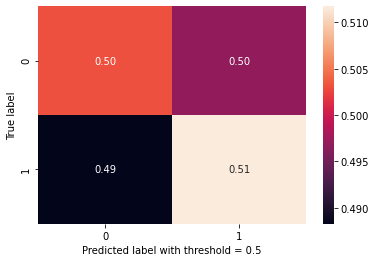

In [143]:
columns = ['True label','Predicted label']

results_pd = pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_pred_vi_discrete)],axis=1)
results_pd.columns = columns

confusion_matrix = pd.crosstab(results_pd['True label'], results_pd['Predicted label'], rownames=['True label'], colnames=['Predicted label with threshold = 0.5']).astype('float') 
confusion_matrix = confusion_matrix/ confusion_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_matrix, annot=True, fmt='.2f')
plt.show()

## Question d

*d) (text) Comment on the tuning of the Metropolis-Hastings algorithm, and how to guarantee that samples are representative of samples of the posterior over model parameters.* [5]

There are two major parameters to tune for the Metropolis-Hastings algorithm: the **number of steps**, and the **step proposal**. Here is a recap of the results we obtained with different sets of parameters for the question 2 c. 


In [92]:
data = [[log_likelihood_01_1000, accuracy_01_1000, fpr_01_1000, tpr_01_1000],
        [log_likelihood_01_10000, accuracy_01_10000, fpr_01_10000, tpr_0_10000],
        [log_likelihood_08_10000, accuracy_08_10000, fpr_08_10000, tpr_08_10000]]
results = pd.DataFrame(data, columns=['LogLikelihood', 'Accuracy', 'False Positive Rate', 'True Positive Rate'], index=['Number of steps = 1 000, Step proposal = 0.1', 'Number of steps = 10 000, Step proposal = 0.1', 'Number of steps = 10 000, Step proposal = 0.8'])
results

,LogLikelihood,Accuracy,False Positive Rate,True Positive Rate
"Number of steps = 1 000, Step proposal = 0.1",-1.037107e+06,54.959,0.472400,0.747081
"Number of steps = 10 000, Step proposal = 0.1",-1.034736e+06,55.062,0.471066,0.745384
"Number of steps = 10 000, Step proposal = 0.8",-1.054216e+06,54.216,0.475745,0.702964


Testing different sets of parameters allows to conclude that: 

- Number of steps: the more the number of steps is high, the more the likelihood descreases. In fact, it allows the algorithm to get nearest to the solution, it is more precise. Thus, we need to **maximize the number of steps**. 
- Step proposal: the smaller the step proposal is, the higher the accuracy is. However, as said before, the accuracy is not a relevant measure. The True Positive Rate shows also that is is better to have a small step proposal (TPR of 74% with a step proposal of 0.1 compared to 70% with a step proposal of 0.8). Thus, we need to **minimize the step proposal**.

However, even if this time the algorithm predicts 1 compared to the Bayesian Linear Regression, the accuracy stays low, and is not a lot better than a random gest.  

### Question e

*e) (text) Comment on the tuning of the variational inference algorithm, and discuss the behavior of the optimization with respect to the choice of the optimizer/step-size.* [5]

There are two major parameters to tune for the variational inference algorithm: the **optimizer**, and the **step size**. Here is a recap of the results we obtained with different sets of parameters for the question 2 c. 

In [0]:
Testing accuracy: 55.062 %
Testing loglikelyhood = -54499832.0
False Positive Rate with variational inference on the Testing set : 0.47574487947455574
True Positive Rate with variational inference on the Testing set : 0.7029643677013674


In [151]:
data = [['-', '-', '-', '-'],
        ['-54499832.0', '55.062 %', '0.475744879', '0.70296437'],
        ['-54499832.0', '55.062 %', '0.475744879', '0.70296437'], 
        ['-54499832.0', '55.062 %', '0.475744879', '0.70296437']]
results = pd.DataFrame(data, columns=['LogLikelihood', 'Accuracy', 'False Positive Rate', 'True Positive Rate'], index=['Optimizer = SDG, learning rate = 1e-2', 'Optimizer = SDG, learning rate = 1e-9', 'Optimizer = SDG, learning rate = 1e-11', 'Optimizer = Adam, learning rate = 1e-5'])
results

,LogLikelihood,Accuracy,False Positive Rate,True Positive Rate
"Optimizer = SDG, learning rate = 1e-2",-,-,-,-
"Optimizer = SDG, learning rate = 1e-9",-54499832.0,55.062 %,0.475744879,0.70296437
"Optimizer = SDG, learning rate = 1e-11",-54499832.0,55.062 %,0.475744879,0.70296437
"Optimizer = Adam, learning rate = 1e-5",-54499832.0,55.062 %,0.475744879,0.70296437


We can tell thanks to our parameters tuning that the algorithm converges for a specific learning rate, which depends on the optimizer. For Stochastic Gradient Descent, the learning rate has to be smaller that 1e-8, and smaller than 1e-3 for Adam.  

However, the results are quite strange as the measures repertorated in the table above are always the same. But the predictions are actually not the same as the confusion matrices computed in the question 2 c are different. 

Moreover, the algorithm doesn't really seem to converge, the plot in the question 2 c it is noisy and does not seem converge toward a specific value. But how to cope with this issue stays a unknown despite a lot of tries and work on this part of the problem...

### Question f

*f) (text) Report the error metrics implemented in (b) and the confusion matrix on the test data. Discuss logistic regression performance with respect to the performance of Bayesian linear regression.* [5]


All the plots and measures are available in the part 2 c (for MCMC and variational inference). 

The major change between Bayesian linear regression and logistic regression is that **logistic regression is able to predict 1**, even if the class is not represented a lot among the dataset. However, the price to pay is a decrease of the accuracy (Bayesian linear regression doesn't take any risk in predicting the dominant class). 

Concerning the two logistic regression algorithms, it seems that MCMC approach works better as the confusion matrix has a strong diagonal (75% of class 1 is well predicted). 

A last remark: **all depends on the application**. If class 1 represents the detection of an anomaly transaction in a bank account, the best thing is to be sure it will be detected. Thus, we prefer to predict that there is an anomaly even if there is not, than to not predict no anomaly if there is one. In this case, Bayesian linear regression is not adapted. 

### Question g

*g) (text) Compare the uncertainties on predictions obtained by the Metropolis-Hastings algorithm and variational inference. First, compare the log-likelihood on test data as a global metric to assess which inference method yields better uncertainty quantification.
Second, pick a few test points for which the mean of the predictive distribution is (a) around 0.5 (b) giving a correct prediction (c) giving a wrong prediction, and visualize/discuss what the predictive distribution looks like. Discuss the difference between the Metropolis-Hastings algorithm and variational inference.* [15]

We obtained best loglikelihood with Metropolis-Hastings algorithm than with variational inference. 

In [0]:
y_pred_MCMC = np.load('/content/drive/My Drive/asi/y_pred_01_10000.npy', allow_pickle=True)
y_pred_vi = np.load('/content/drive/My Drive/asi/y_pred_SGD_11.npy', allow_pickle=True)

In [0]:
y_pred_MCMC_discrete = discrete(0.5, y_pred_MCMC)
y_pred_vi_discrete = discrete(0.5, y_pred_vi)

In [0]:
y_diff_MCMC = np.absolute(y_pred_MCMC_discrete - y_test)
y_diff_vi = np.absolute(y_pred_vi_discrete - y_test)

In [0]:
def count(target, y):
  compt = 0
  for i in range(len(y)):
    if y[i] == target:
      compt += 1
  return compt

In [0]:
uncertain_points_MCMC = len(np.intersect1d(np.where(y_pred_MCMC>0.3), np.where(y_pred_MCMC<0.7)))
correct_points_MCMC = count(0, y_diff_MCMC)
wrong_points_MCMC = count(1, y_diff_MCMC)

uncertain_points_vi = len(np.intersect1d(np.where(y_pred_vi>0.3), np.where(y_pred_vi<0.7)))
correct_points_vi = count(0, y_diff_vi)
wrong_points_vi = count(1, y_diff_vi)

Here is the plot asked.

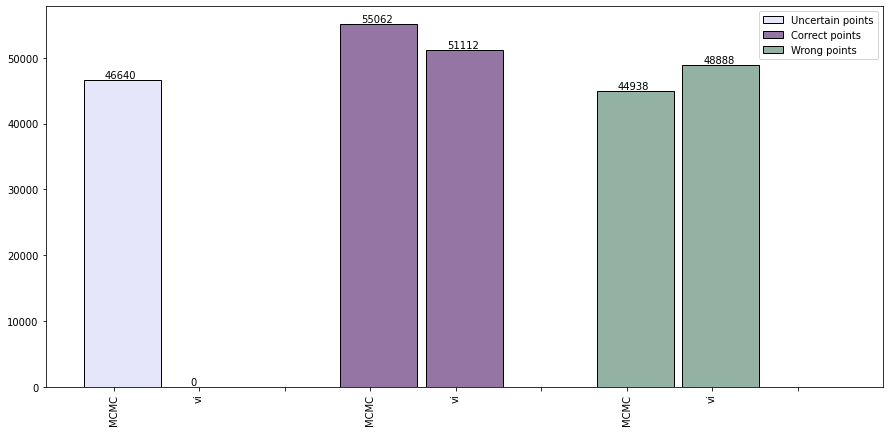

In [191]:
# Create bars

plt.figure(figsize=(15,7))
barWidth = 0.9

bars1 = [uncertain_points_MCMC, uncertain_points_vi, 0]
bars2 = [correct_points_MCMC, correct_points_vi, 0]
bars3 = [wrong_points_MCMC, wrong_points_vi, 0]
bars4 = bars1 + bars2 + bars3
 
# The X position of bars
r1 = [1,2,3]
r2 = [4,5,6]
r3 = [7,8,9]
r4 = r1 + r2 + r3
 
# Create barplot
plt.bar(r1, bars1, width = barWidth, color = 'lavender', label='Uncertain points', edgecolor = 'black')
plt.bar(r2, bars2, width = barWidth, color = (0.3,0.1,0.4,0.6), label='Correct points', edgecolor = 'black')
plt.bar(r3, bars3, width = barWidth, color = (0.3,0.5,0.4,0.6), label='Wrong points', edgecolor = 'black')
 
# Create legend
plt.legend()
 
# Text below each barplot with a rotation at 90°
plt.xticks([r + barWidth for r in range(len(r4))], ['MCMC', 'vi', '', 'MCMC', 'vi', '', 'MCMC', 'vi', ''], rotation=90)
 
# Create labels
label = [bars1[0], bars1[1], '', bars2[0], bars2[1], '', bars3[0], bars3[1]]
 
# Text on the top of each barplot
for i in range(len(r4)-1):
    plt.text(x = r4[i]-0.2 , y = bars4[i]+300, s = label[i], size = 10)
 
# Adjust the margins
#plt.subplots_adjust(bottom= 0.2, top = 0.98)
plt.show()

As discussed earlier, MCMC seems to perform well as it computes more correct points (and thus less incorrect points). However, we can also see that MCMC is very uncertain for a lot of samples (almost a half), which can also be an issue if we want our algorithm to sure about its results (all depends on the applicaiton). 